In [264]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import time
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from tests import test_prediction, test_generation

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cpu'

In [265]:
TIE_WEIGHT = True

In [266]:
# load all that we need

dataset = np.load('../dataset/wiki.train.npy')
fixtures_pred = np.load('../fixtures/dev_fixtures/prediction.npz')  # dev
fixtures_gen = np.load('../fixtures/dev_fixtures/generation.npy')  # dev
fixtures_pred_test = np.load('../fixtures/test_fixtures/prediction.npz')  # test
fixtures_gen_test = np.load('../fixtures/test_fixtures/generation.npy')  # test
vocab = np.load('../dataset/vocab.npy')

In [267]:
# data loader

# Using the generator pattern (an iterable)
class dataLoaderIter(object):
    def __init__(self, dataLoader):
        self.batch_num = dataLoader.batch_num
        self.inputs = dataLoader.inputs
        self.targets = dataLoader.targets
        
        self.ctr = 0
        self.seq = 70
        self.p = 0.95
        
    def __iter__(self):
        return self

    # Python 3 compatibility
    def __next__(self):
        return self.next()

    def next(self):
        if self.ctr < self.batch_num:

            if np.random.random() < self.p:
                seq_len = self.seq
            else:
                seq_len = self.seq / 2

            seq_len = int(np.random.normal(loc=seq_len, scale=5))
            cur, self.ctr = self.ctr, self.ctr + seq_len
            
            return (torch.tensor(self.inputs[cur : cur + seq_len]).long(),
                    torch.tensor(self.targets[cur : cur + seq_len]).long())
        
        else:
            raise StopIteration()

class LanguageModelDataLoader(DataLoader):
    """
        TODO: Define data loader logic here
    """
    def __init__(self, dataset, batch_size, shuffle=True):
        self.dataset = dataset
        self.shuffle = shuffle
        #Randomly shuffle dataset
        if self.shuffle:
            np.random.shuffle(self.dataset)
        self.dataset = np.concatenate(self.dataset)

        #Find batch_num
        self.batch_size = batch_size
        self.batch_num = len(self.dataset) // batch_size
        
        #Staggered inputs and ouputs
        self.inputs = np.resize(self.dataset[:-1], (self.batch_size, self.batch_num)).T
        self.targets = np.resize(self.dataset[1:], (self.batch_size, self.batch_num)).T
        
#         print(self.batch_size, self.batch_num)
#         print(self.inputs.shape, self.targets.shape)
#         print(dataset.shape, (self.dataset.shape))
#         print(self.batch_num)
        
    def __iter__(self):
        return dataLoaderIter(self)

        
        

In [268]:
# Test for dataloader
# loader = LanguageModelDataLoader(dataset=dataset, batch_size=32, shuffle=True)
# for i in loader.__iter__():
#     print (i[0].size())

In [269]:
# model for future... You know you should version control haha

# class LanguageModel(nn.Module):
#     """
#         TODO: Define your model here
#     """
    
#     def __init__(self,vocab_size):
#         super(LanguageModel,self).__init__()
#         self.vocab_size = vocab_size
#         self.embed_size = 400
#         self.hidden_size = 1150
#         self.nlayers = 3
#         self.embedding = nn.Embedding(self.vocab_size, self.embed_size) # Embedding layer
#         self.rnn = nn.LSTM(input_size=self.embed_size, hidden_size=self.hidden_size, num_layers=self.nlayers) # Recurrent network
#         self.scoring = nn.Linear(self.hidden_size, self.vocab_size) # Projection layer
        
#     def forward(self,seq_batch,hidden): #L x N
#         # returns 3D logits
#         batch_size = seq_batch.size(1)
#         embed = self.embedding(seq_batch) #L x N x E
#         hidden = None
#         output_lstm,hidden = self.rnn(embed, hidden) #L x N x H
#         output_lstm_flatten = output_lstm.view(-1, self.hidden_size) #(L*N) x H
#         output_flatten = self.scoring(output_lstm_flatten) #(L*N) x V
#         return output_flatten.view(-1, batch_size, self.vocab_size), hidden
    

In [270]:
from torch.autograd import Variable

class LockedDropout(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input, dropout=0.5):
        m = input.data.new(1, input.size(1), input.size(2)).bernoulli_(1 - dropout)
        mask = Variable(m, requires_grad=False) / (1 - dropout)
        mask = mask.expand_as(input)
        return mask * input

In [271]:
# model

class LanguageModel(nn.Module):
    """
        TODO: Define your model here
    """
    
    def __init__(self,vocab_size):
        super(LanguageModel,self).__init__()
        self.vocab_size = vocab_size
        self.embed_size = 400
        self.hidden_size = 1150
        self.nlayers = 3
        self.encoder = nn.Embedding(self.vocab_size, self.embed_size) # Embedding layer
        self.rnns = [nn.LSTM(input_size=self.embed_size, hidden_size=self.hidden_size),
                     nn.LSTM(input_size=self.hidden_size, hidden_size=self.hidden_size),
                     nn.LSTM(input_size=self.hidden_size, hidden_size=self.embed_size)]
        self.rnn = nn.ModuleList(self.rnns) # LSTM
        self.decoder = nn.Linear(self.embed_size, self.vocab_size) # Projection layer
        self.lock_dropout = LockedDropout()
        
        self.init_weight()
        # Optimizations
        if TIE_WEIGHT:
            self.encoder.weight = self.decoder.weight
    
#     def lock_dropout(self):
    
    def embed_dropout(self, input, p=0.1):
        new_weight = (self.encoder.weight.data.new().resize_((self.encoder.weight.size(0), 1)).bernoulli_(1 - p).expand_as(self.encoder.weight) / (1 - p)) * self.encoder.weight
        new_embedding = torch.nn.functional.embedding(input, new_weight, -1, self.encoder.max_norm, self.encoder.norm_type,
                        self.encoder.scale_grad_by_freq, self.encoder.sparse)
        return new_embedding
    
    def init_weight(self):
        self.encoder.weight.data.uniform_(-0.1, 0.1)
        self.decoder.bias.data.fill_(0)
        self.decoder.weight.data.uniform_(-0.1, 0.1)
    
    # hidden is made of two diff things apparently.. cell and hidden state
    def forward(self,seq_batch, hidden): #L x N
        # returns 3D logits
        batch_size = seq_batch.size(1)
#         embed = self.encoder(seq_batch) #L x N x E
        embed = self.embed_dropout(seq_batch)
        embed = self.lock_dropout(embed)
        output_lstm = embed
        new_hiddens = []
        for i, l in enumerate(self.rnn):
            output_lstm, new_hidden = l(output_lstm, hidden[i])
            new_hiddens.append(new_hidden)
            if l != 2:
                output_lstm = self.lock_dropout(output_lstm)
        hidden = new_hiddens
        output_lstm = self.lock_dropout(output_lstm)
        output_lstm_flatten = output_lstm.view(-1, self.embed_size) #(L*N) x H
        output_flatten = self.decoder(output_lstm_flatten) #(L*N) x V
        return output_flatten.view(-1, batch_size, self.vocab_size), hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        return [(Variable(weight.new(1, batch_size, self.hidden_size).zero_()),
                Variable(weight.new(1, batch_size, self.hidden_size).zero_())),
               (Variable(weight.new(1, batch_size, self.hidden_size).zero_()),
                Variable(weight.new(1, batch_size, self.hidden_size).zero_())),
               (Variable(weight.new(1, batch_size, self.embed_size).zero_()),
                Variable(weight.new(1, batch_size, self.embed_size).zero_()))]
    

In [272]:
import time

In [273]:
# model trainer

# Temporary optim I don't want to implement ASGD
import torch.optim as optim
class LanguageModelTrainer:
    def __init__(self, model, loader, max_epochs=1, run_id='exp'):
        """
            Use this class to train your model
        """
        # feel free to add any other parameters here
        self.model = model
        self.loader = loader
        self.train_losses = []
        self.val_losses = []
        self.predictions = []
        self.predictions_test = []
        self.generated_logits = []
        self.generated = []
        self.generated_logits_test = []
        self.generated_test = []
        self.epochs = 0
        self.max_epochs = max_epochs
        self.run_id = run_id
        
        # TODO: Define your optimizer and criterion here
        self.optimizer = optim.Adam(self.model.parameters(), 0.001)
        self.criterion = nn.CrossEntropyLoss()
        self.criterion = self.criterion.to(DEVICE)

    def train(self):
        self.model.train() # set to training mode
        epoch_loss = 0
        num_batches = 0
        print('starting training',time.strftime('%l:%M%p %Z on %b %d, %Y'))
        start_time = time.time()
        batch_start_time = start_time
        for batch_num, (inputs, targets) in enumerate(self.loader):
            epoch_loss += self.train_batch(inputs, targets)
            if batch_num % 10 == 0:
                print(batch_num+1, epoch_loss/(batch_num+1))
                curr_time = time.time()
                print('Time elapsed:', time.strftime('%H:%M:%S', time.gmtime(curr_time - batch_start_time)))
                batch_start_time = time.time()
        
        curr_time = time.time()
        print('Time elapsed:', time.strftime('%H:%M:%S', time.gmtime(curr_time - start_time)))
        
        epoch_loss = epoch_loss / (batch_num + 1)
        self.epochs += 1
        print('[TRAIN]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs, self.max_epochs, epoch_loss))
        self.train_losses.append(epoch_loss)

    def train_batch(self, inputs, targets):
        """ 
            TODO: Define code for training a single batch of inputs
        
        """
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)
        
        hidden = self.model.init_hidden(BATCH_SIZE)
        train_outputs = self.model(inputs,hidden)[0]
        train_loss = self.criterion(train_outputs.view(-1,train_outputs.size(2)),targets.view(-1))
        self.optimizer.zero_grad()
        train_loss.backward()
        self.optimizer.step()
        return train_loss.item()

    
    def test(self):
        # don't change these
        self.model.eval() # set to eval mode
        predictions = TestLanguageModel.prediction(fixtures_pred['inp'], self.model) # get predictions
        self.predictions.append(predictions)
        nll = test_prediction(predictions, fixtures_pred['out'])
        
        generated_logits = TestLanguageModel.generation(fixtures_gen, 10, self.model) # predictions for 20 words
        generated_logits_test = TestLanguageModel.generation(fixtures_gen_test, 10, self.model) # predictions for 20 words

        generated = test_generation(fixtures_gen, generated_logits, vocab)
        generated_test = test_generation(fixtures_gen_test, generated_logits_test, vocab)
        self.val_losses.append(nll)
        
        self.generated.append(generated)
        self.generated_test.append(generated_test)
        self.generated_logits.append(generated_logits)
        self.generated_logits_test.append(generated_logits_test)
        
        # generate predictions for test data
        predictions_test = TestLanguageModel.prediction(fixtures_pred_test['inp'], self.model) # get predictions
        self.predictions_test.append(predictions_test)
            
        print('[VAL]  Epoch [%d/%d]   NLL: %.4f'
                      % (self.epochs, self.max_epochs, nll))
        return nll

    def save(self):
        # don't change these
        model_path = os.path.join('experiments', self.run_id, 'model-{}.pkl'.format(self.epochs))
        torch.save({'state_dict': self.model.state_dict()},
            model_path)
        np.save(os.path.join('experiments', self.run_id, 'predictions-{}.npy'.format(self.epochs)), self.predictions[-1])
        np.save(os.path.join('experiments', self.run_id, 'predictions-test-{}.npy'.format(self.epochs)), self.predictions_test[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-{}.npy'.format(self.epochs)), self.generated_logits[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-test-{}.npy'.format(self.epochs)), self.generated_logits_test[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-test-{}.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated_test[-1])


In [274]:
class TestLanguageModel:
    def prediction(inp, model):
        # Apparently batch_size * sequence_length
        # In my case seq length does not matter but batchsize does..
        # The returned array should be [batch size, vocabulary size]
        """
            TODO: write prediction code here
            
            :param inp:
            :return: a np.ndarray of logits
        """
        batch_size = inp.shape[0]
        inp_tensor = torch.tensor(inp.T).long()
        inp_tensor = inp_tensor.to(DEVICE)
        
        hidden = model.init_hidden(batch_size)
        val_outputs,_ = model(inp_tensor,hidden)
        val_outputs = val_outputs.cpu().detach().numpy()
        val_outputs = val_outputs[-1]
#         print(val_outputs, val_outputs.shape)
        return val_outputs

        
    def generation(inp, forward, model):
        """
            TODO: write generation code here

            Generate a sequence of words given a starting sequence.
            :param inp: Initial sequence of words (batch size, length)
            :param forward: number of additional words to generate
            :return: generated words (batch size, forward)
        """
#         print(inp.shape[0],inp.shape[1],forward)
        generated_words = []
        batch_size = inp.shape[0]

        inp_tensor = torch.tensor(inp.T).long()
        inp_tensor = inp_tensor.to(DEVICE)
        
#         embed = model.embedding(inp_tensor)
#         hidden = None
#         output_lstm, hidden = model.rnn(embed, hidden)
#         output = output_lstm[-1]
#         scores = model.scoring(output)
#         _, current_word = torch.max(scores, dim=1)
#         generated_words.append(current_word.unsqueeze(0))
        
#         if forward > 1 :
#             for i in range(forward - 1):
#                 embed = model.embedding(current_word).unsqueeze(0)
#                 output_lstm, hidden = model.rnn(embed, hidden)
#                 output = output_lstm[0]
#                 scores = model.scoring(output)
#                 _, current_word = torch.max(scores, dim=1)
#                 generated_words.append((current_word.unsqueeze(0)))
#         generated_words = torch.cat(generated_words, dim=0)
#         return torch.Tensor.transpose(generated_words,0,1)
        hidden = model.init_hidden(batch_size)
        output = inp_tensor
        for i in range(forward):
            scores, hidden_new = model(output, hidden)
#             print(scores.size())
            _, current_word = torch.max(scores, dim=2)
#             print(current_word.size(),current_word[-1])
            generated_words.append((current_word[-1].unsqueeze(0)))
            output = current_word
            hidden = hidden_new
        generated_words = torch.cat(generated_words, dim=0)
        res =  torch.Tensor.transpose(generated_words, 0, 1)
#         print(res.size())
        return res

In [279]:
# TODO: define other hyperparameters here

NUM_EPOCHS = 10
BATCH_SIZE = 80


In [276]:
run_id = str(int(time.time()))
if not os.path.exists('./experiments'):
    os.mkdir('./experiments')
os.mkdir('./experiments/%s' % run_id)
print("Saving models, predictions, and generated words to ./experiments/%s" % run_id)

Saving models, predictions, and generated words to ./experiments/1540696200


In [280]:
model = LanguageModel(len(vocab))
model = model.to(DEVICE)
loader = LanguageModelDataLoader(dataset=dataset[:5], batch_size=BATCH_SIZE, shuffle=True)
trainer = LanguageModelTrainer(model=model, loader=loader, max_epochs=NUM_EPOCHS, run_id=run_id)

In [281]:
best_nll = 1e30  # set to super large value at first
for epoch in range(NUM_EPOCHS):
    trainer.train()
    nll = trainer.test()
    if nll < best_nll:
        best_nll = nll
        print("Saving model, predictions and generated output for epoch " + 
              str(epoch)+" with NLL: " + str(best_nll))
        trainer.save()
    

starting training 11:15PM EDT on Oct 27, 2018
1 10.414969444274902
Time elapsed: 00:00:28
Time elapsed: 00:01:33
[TRAIN]  Epoch [1/10]   Loss: 10.2166
[VAL]  Epoch [1/10]   NLL: 9.3117
Saving model, predictions and generated output for epoch 0 with NLL: 9.311734
starting training 11:18PM EDT on Oct 27, 2018
1 9.606433868408203
Time elapsed: 00:00:11
Time elapsed: 00:01:36
[TRAIN]  Epoch [2/10]   Loss: 9.2067
[VAL]  Epoch [2/10]   NLL: 8.4749
Saving model, predictions and generated output for epoch 1 with NLL: 8.474861
starting training 11:20PM EDT on Oct 27, 2018
1 8.517975807189941
Time elapsed: 00:00:37
Time elapsed: 00:01:50
[TRAIN]  Epoch [3/10]   Loss: 8.2267
[VAL]  Epoch [3/10]   NLL: 8.8980
starting training 11:23PM EDT on Oct 27, 2018
1 10.388459205627441
Time elapsed: 00:00:23
Time elapsed: 00:01:45
[TRAIN]  Epoch [4/10]   Loss: 8.3450
[VAL]  Epoch [4/10]   NLL: 7.8498
Saving model, predictions and generated output for epoch 3 with NLL: 7.8498363
starting training 11:26PM EDT 

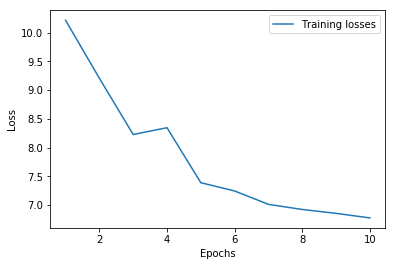

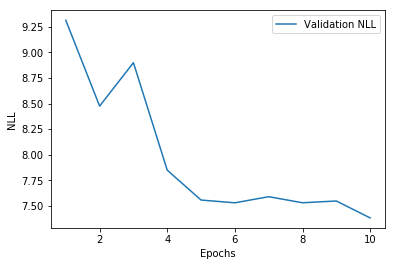

In [282]:
# Don't change these
# plot training curves
plt.figure()
plt.plot(range(1, trainer.epochs + 1), trainer.train_losses, label='Training losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(1, trainer.epochs + 1), trainer.val_losses, label='Validation NLL')
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.legend()
plt.show()

In [283]:
# see generated output
print (trainer.generated[-1]) # get last generated output

Input | Output #0: while the group was en route , but only three were ultimately able to attack . None of them were | the in . the the , the , be of
Input | Output #1: <unk> , where he remained on loan until 30 June 2010 . <eol> = = = Return to Manchester United | in , and , , his the the , ,
Input | Output #2: 25 April 2013 , denoting shipments of 500 @,@ 000 copies . <eol> The song became One Direction 's fourth | his a , , <unk> , of of , of
Input | Output #3: , and Bruce R. ) one daughter ( Wendy J. <unk> ) and two grandchildren , died in <unk> , | be <unk> , the , the of the the the
Input | Output #4: Warrior were examples of this type . Because their armor was so heavy , they could only carry a single | , , , , the . the the , <unk>
Input | Output #5: the embassy at 1 : 49 and landed on Guam at 2 : 23 ; twenty minutes later , Ambassador | and the a the the and , , , .
Input | Output #6: <unk> , $ 96 million USD ) . Damage was heaviest in South Korea , notably where it moved ashor